In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular

import tornadox
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import pof
from pof.main import (
    make_continuous_models,
    discretize_transitions,
    get_constant_initial_trajectory,
    linearize_observation_model,
    taylor_mode_init,
)
from pof.ieks import filtsmooth, smoothing
from pof.solve import solve_diffrax
from pof.utils import tria

First define the IVP and compute a reference solution with diffrax

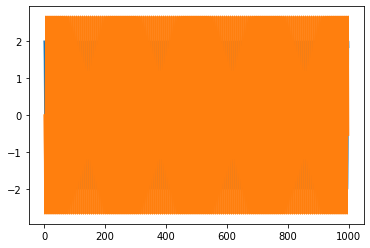

In [16]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=1000)
ts_true, ys_true, sol_true = solve_diffrax(ivp, rtol=1e-10, atol=1e-10)
plt.plot(ts_true, ys_true)

We now want to solve it with a time-parallel IEKS.

# Solving IVPs with the IEKS
We already did this in previous notebooks, but now the structure is a bit different: first create a continuous model, then discretize it, and then run a linear filter/smoother on that.

In [17]:
order = 5
dt = 1e-2

In [18]:
# define the time grid
ts = jnp.arange(0, ivp.tmax + dt, dt)
# make a constant initial trajectory from y0
traj = get_constant_initial_trajectory(ivp.y0, order, len(ts))

# make the continuous transition and observation models
iwp, om = make_continuous_models(ivp, order)
E0 = pof.transitions.projection_matrix(iwp, 0)

# make the discrete transition and observation model
dtm = discretize_transitions(iwp, ts)
lom = jax.jit(linearize_observation_model, static_argnums=0)
dom = lom(om, traj[1:])

# for the initial guess, use Taylor-mode autodiff as usual via tornadox
x0 = taylor_mode_init(ivp, order)

In [19]:
%%time
fs = jax.jit(filtsmooth)

CPU times: user 170 µs, sys: 20 µs, total: 190 µs
Wall time: 199 µs


CPU times: user 4.89 s, sys: 2.24 s, total: 7.13 s
Wall time: 7.12 s


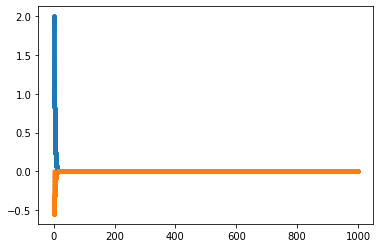

In [20]:
%%time
out = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")

  0%|          | 0/10 [00:00<?, ?it/s]

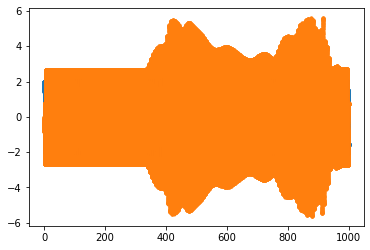

In [22]:
ITERS = 100
for i in trange(ITERS):
    dom = lom(om, out.mean[1:])
    out = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")

  0%|          | 0/100 [00:00<?, ?it/s]

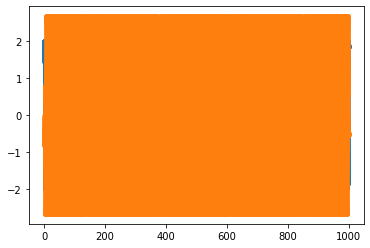

In [23]:
ITERS = 100
for i in trange(ITERS):
    dom = lom(om, out.mean[1:])
    out = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")

In [ ]:
_ts, _ys, _ = solve_diffrax(ivp, dt=dt)

err_final_dp5 = ys_true[-1] - _ys[-1]
err_final_ieks = ys_true[-1] - (E0 @ out.mean[-1])
(err_final_dp5, err_final_ieks)